In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [2]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [4]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
train['Pclass'] = train['Pclass'].astype(str)
train.drop(['Name'], axis=1, inplace=True)
train['Age'].fillna(train['Age'].mean(), inplace=True)

In [6]:
# Import necessary packages
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [7]:
# split the train dataframe into two where the Cabin column is NaN and not NaN  
train_wc = train[~train['Cabin'].isna()]
train_wc = train_wc[train_wc['Cabin'] != 'T']
train_wc['Cabin'] = train_wc['Cabin'].map(lambda x : x[0])

train_woc = train[train['Cabin'].isna()]
train_woc = train_woc.drop(['Cabin', 'PassengerId'], axis=1)

In [8]:
train_woc_X = train_woc.drop(columns = ['Survived', 'Ticket'])
train_woc_X = pd.get_dummies(train_woc_X, drop_first=True)

X = train_woc_X.values
y = train_woc['Survived'].values

In [9]:
# Split the data into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

# Scale the data
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_scaled = scaler.fit_transform(X)

In [10]:
# Load the model
logreg = LogisticRegression(max_iter = 100)

# Fit the data to the model
logreg.fit(X_train_scaled, y_train)

LogisticRegression()

In [11]:
# Accuracy of the model
logreg.score(X_test_scaled, y_test)

0.8067632850241546

In [12]:
logreg.coef_

array([[-0.42612122, -0.52616128, -0.19060231,  0.33055473,  0.032874  ,
        -0.47462816, -1.27551976,  0.08294948, -0.09037269]])

<BarContainer object of 9 artists>

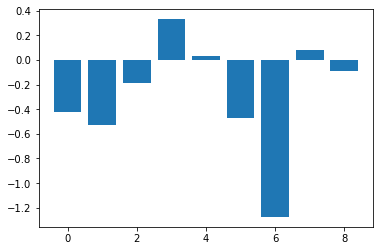

In [13]:
plt.bar( x= np.arange(0,9) ,height = logreg.coef_[0])

### Cross Validation

In [14]:
# Accuracy of the model
logreg.score(X_test_scaled, y_test)

# Use cross-validation to check the accuracy of the model
kf = KFold(n_splits=8, shuffle=True)

logreg = LogisticRegression(max_iter=1000)

cross_val_scores = cross_val_score(logreg, X_scaled, y, cv=kf)

print('mean of the CV Scores is {}'.format(np.mean(cross_val_scores)))

mean of the CV Scores is 0.8165868673050615


### ROC Curve

In [15]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

In [16]:
y_pred = logreg.predict(X_test_scaled)
y_pred_prob = logreg.predict_proba(X_test_scaled)[:,1]

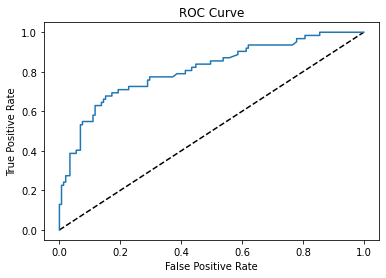

ROC AUC Score of the model is 0.8094549499443826


In [17]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

plt.show()

print('ROC AUC Score of the model is {}'.format(roc_auc_score(y_test, y_pred_prob)))

### Hyperparameter Tuning

In [18]:
from sklearn.model_selection import GridSearchCV

kf = KFold(n_splits=6, shuffle=True)#, random_state=6)

logreg = LogisticRegression(max_iter=1000)

param_grid = {'C':np.linspace(0.001,1,20 )}

logreg_cv = GridSearchCV(logreg, param_grid, cv=kf)

logreg_cv.fit(X_train_scaled, y_train)

# best parameters
print(logreg_cv.best_params_)

{'C': 0.05357894736842105}


In [19]:
logreg_cv.best_estimator_.score(X_test_scaled, y_test)

0.8067632850241546

### With Cabin

In [20]:
train_wc_X = train_wc.drop(columns = ['Survived', 'Ticket', 'Cabin'])
train_wc_X = pd.get_dummies(train_wc_X, drop_first=True)

X_c = train_wc_X.values
y_c = train_wc['Survived'].values

In [21]:
X_c_train, X_c_test, y_c_train, y_c_test = train_test_split(X_c, y_c, test_size=0.3)

logreg = LogisticRegression(max_iter=1000)

logreg.fit(X_c_train,y_c_train)

LogisticRegression(max_iter=1000)

In [22]:
logreg.score(X_c_test, y_c_test)

0.7540983606557377